## TODO

- [ ] 

## Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from bitcoin_deep_learning.call_api import ApiCall
from bitcoin_deep_learning.model import RnnDlModel, LinearRegressionBaselineModel, DummyModel
from bitcoin_deep_learning.trainer import train, read_result
from bitcoin_deep_learning.cross_val import get_cross_XY
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import random
import joblib
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

## Getting data

In [3]:
X_train_list, Y_train_list, X_test_list,Y_test_list = get_cross_XY()

In [4]:
np.array(X_train_list).shape

(32, 263, 90, 32)

In [5]:
fold_id = 0

In [6]:
X_train, y_train, X_test, y_test = X_train_list[fold_id], Y_train_list[fold_id], X_test_list[fold_id], Y_test_list[fold_id]

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(263, 90, 32)
(263,)
(90, 90, 32)
(90,)


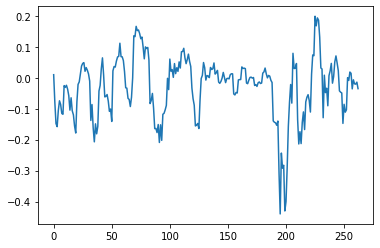

In [8]:
plt.plot(y_train)

## Preprocess for Dart

### Convert data to `TimeSeries`

In [9]:
from darts import TimeSeries

In [10]:
df = ApiCall().read_local(data='train')
df_test = ApiCall().read_local(data='test')

In [11]:
target_name = "[+]_[T]_Bitcoin_Price"#"[%]_Bitcoin_growth_rate_on_Horizon=7"

In [12]:
# Set index as datetime
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)
df.shape

(1406, 32)

In [13]:
df = df[df.index < "2021-08-01"]

In [14]:
# Set index as datetime
df_test["date"] = pd.to_datetime(df_test["date"])
df_test.set_index("date", inplace=True)
df_test.shape

(457, 32)

In [15]:
# Drop days to clearly separate test from rest
df_test = df_test[df_test.index > df.sort_index().last_valid_index()]

In [16]:
test_start_date = df_test.sort_index().first_valid_index()
test_start_date

Timestamp('2021-08-01 00:00:00')

### Create `features_train`, `features_test`, `target_train`, `target_test`

`features` are our past covariates

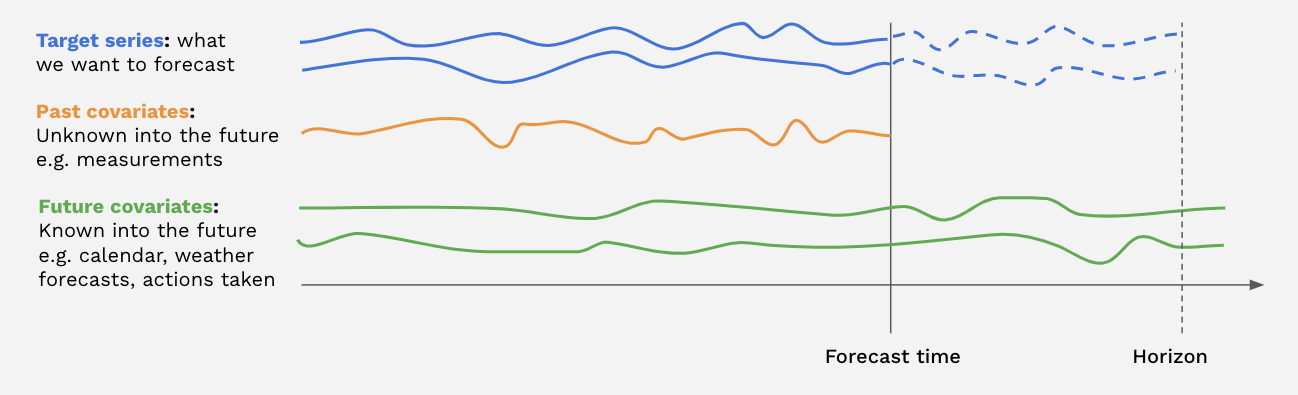

In [17]:
features = TimeSeries.from_dataframe(df.drop(columns=target_name)).astype(np.float32)
target = TimeSeries.from_dataframe(df[[target_name]]).astype(np.float32)

In [18]:
features_test = TimeSeries.from_dataframe(df_test.drop(columns=target_name)).astype(np.float32)
target_test = TimeSeries.from_dataframe(df_test[[target_name]]).astype(np.float32)

In [19]:
val_start_date = pd.Timestamp("2021-03-01")

In [20]:
features_train, features_val = features.split_before(val_start_date)
target_train, target_val = target.split_before(val_start_date)

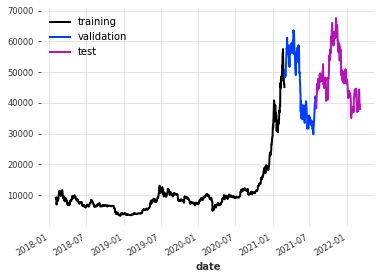

In [21]:
target_train.plot(label="training")
target_val.plot(label="validation")
target_test.plot(label="test")

### Scaling

Let's scale our data

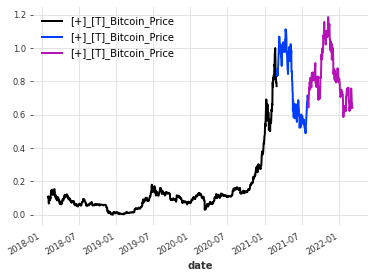

In [22]:
from darts.dataprocessing.transformers import Scaler
scaler = Scaler()
features_train, target_train = scaler.fit_transform([features_train, target_train])
features_val, target_val = scaler.transform([features_val, target_val])
features_test, target_test = scaler.transform([features_test, target_test])
target_train.plot()
target_val.plot()
target_test.plot()

## Dart Models

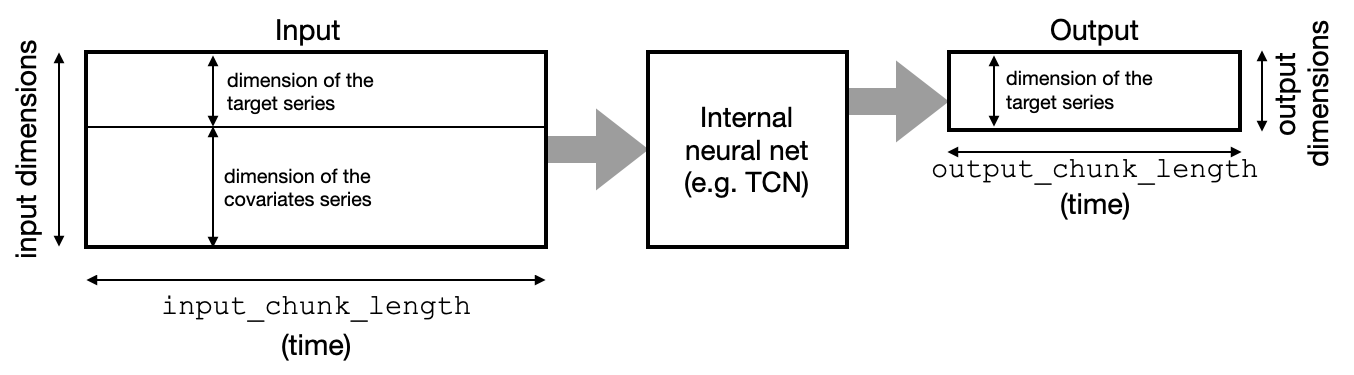

In [23]:
input_chunk_length = 30
output_chunk_length = 7 # TODO: should I use 1 or 7 here?

#### NBEATS

In [24]:
from darts.models import NBEATSModel
model = NBEATSModel(input_chunk_length=input_chunk_length, 
                    output_chunk_length=output_chunk_length)

In [26]:
model.fit(series=target_train,
    past_covariates=features_train,
    epochs=10,
    val_series=target_val,
    val_past_covariates=features_val
)

[2022-03-10 09:34:47,618] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1088 samples.
[2022-03-10 09:34:47,618] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1088 samples.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
[2022-03-10 09:34:47,627] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = NBEATSModel.load_from_checkpoint(model_name, best=False)`. Finally, train the model with `model.fit(..., epochs=new_epochs)` where `new_epochs` is the sum of (epochs already trained + some additional epochs).
[2022-03-10 09:34:47,627] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [73]:
preds = model.predict(series=target_train, past_covariates=features_train, n=7)

Predicting: 34it [00:00, ?it/s]

#### backtest on train set

In [77]:
# TODO: check if data leaks here?

In [ ]:
historical_forecasts = model.historical_forecasts(series=target_train,
                           past_covariates=features_train,
                           start=0.9, # first point of time at which a prediction is computed for a future time.
                           forecast_horizon=7,
                           stride=7, # The number of time steps between two consecutive predictions
                           retrain=True, # Whether to retrain the model for every prediction or not.
                        )

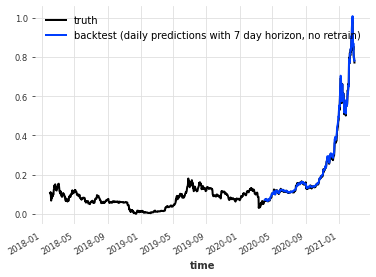

In [75]:
%matplotlib inline
target_train.plot(label='truth')
historical_forecasts.plot(label='backtest (daily predictions with 7 day horizon, no retrain)')

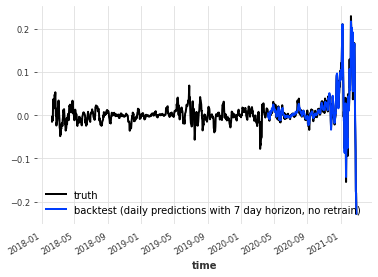

In [76]:
target_train.diff(periods=7).plot(label='truth')
historical_forecasts.diff(periods=7).plot(label='backtest (daily predictions with 7 day horizon, no retrain)')

#### Backtest on test set (with retrain at every stride)

In [61]:
backtest_start_date = pd.Timestamp("2021-11-01")

In [ ]:
historical_forecasts_test = model.historical_forecasts(series=target_test,
                           past_covariates=features_test,
                           start=0.9, # first point of time at which a prediction is computed for a future time.
                           forecast_horizon=7,
                                                       
                           stride=7, # The number of time steps between two consecutive predictions
                           retrain=True, # Whether to retrain the model for every prediction or not.
                           verbose=False)

[2022-03-10 10:01:31,762] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 160 samples.
[2022-03-10 10:01:31,762] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 160 samples.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
[2022-03-10 10:01:31,786] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = NBEATSModel.load_from_checkpoint(model_name, best=False)`. Finally, train the model with `model.fit(..., epochs=new_epochs)` where `new_epochs` is the sum of (epochs already trained + some additional epochs).
[2022-03-10 10:01:31,786] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a

Training: 0it [00:00, ?it/s]

/Users/brunolajoie/.pyenv/versions/3.8.12/envs/lewagon3812/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Predicting: 1it [00:00, ?it/s]

[2022-03-10 10:01:35,610] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 167 samples.
[2022-03-10 10:01:35,610] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 167 samples.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
[2022-03-10 10:01:35,619] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = NBEATSModel.load_from_checkpoint(model_name, best=False)`. Finally, train the model with `model.fit(..., epochs=new_epochs)` where `new_epochs` is the sum of (epochs already trained + some additional epochs).
[2022-03-10 10:01:35,619] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a

Training: 0it [00:00, ?it/s]

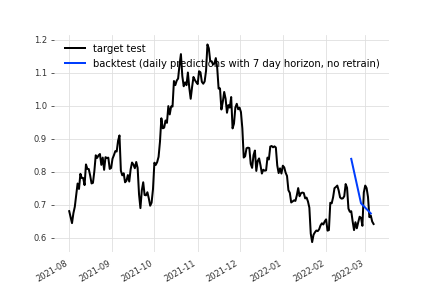

In [28]:
%matplotlib widget
target_test.plot(label='target test')
historical_forecasts_test.plot(label='backtest (daily predictions with 7 day horizon, no retrain)')

[2022-03-10 10:01:03,340] ERROR | darts.timeseries | ValueError: The time series array must not be empty.


ValueError: The time series array must not be empty.

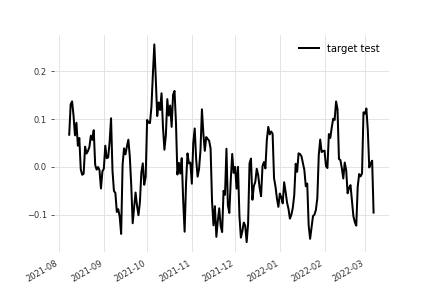

In [29]:
%matplotlib widget
target_test.diff(periods=7).plot(label='target test')
historical_forecasts_test.diff(periods=7).plot(label='backtest (daily predictions with 7 day horizon, no retrain)')

In [40]:
# I'm suspicious: Let's double check that manually! 

Predicting: 34it [00:00, ?it/s]

(18628.0, 18748.0)

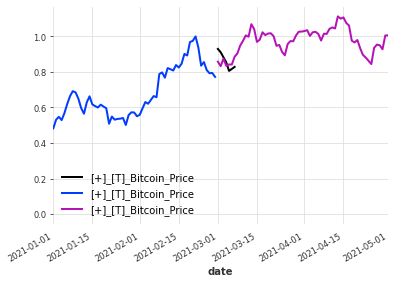

In [55]:
model.predict(series=target_train, past_covariates=features_train, n=7).plot()
target_train.plot()
target_val.plot()
plt.xlim(xmin=pd.Timestamp('2021-01-01'), xmax=pd.Timestamp('2021-05-01'))

#### Transformer

In [39]:
from darts.models import TransformerModel
model_transformer = TransformerModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length)

model.fit(series=target_train,
    past_covariates=features_train,
    val_series=target_val,
    val_past_covariates=features_val,
    num_loader_workers=1
)

[2022-03-09 09:56:01,202] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1088 samples.
[2022-03-09 09:56:01,202] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1088 samples.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
[2022-03-09 09:56:01,212] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = NBEATSModel.load_from_checkpoint(model_name, best=False)`. Finally, train the model with `model.fit(..., epochs=new_epochs)` where `new_epochs` is the sum of (epochs already trained + some additional epochs).
[2022-03-09 09:56:01,212] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
historical_forecasts_test_transformer = model_transformer.historical_forecasts(
    series=target_test,
    past_covariates=features_test,
    start=pd.Timestamp("2021-11-01"),  # first point of time at which a prediction is computed for a future time.
    forecast_horizon=7,
    stride=1,  # The number of time steps between two consecutive predictions
    retrain=False,  # Whether to retrain the model for every prediction or not.
    verbose=False)

In [ ]:
%matplotlib inline
target_test.plot(label='target')
historical_forecasts_test_transformer.plot(label='backtest daily predictions with 7 day horizon - No retrain')

In [ ]:
# TODO : undertand why the backtesting leaks. Maybe we have to "retrain=True" ? 

## Statistics

In [ ]:
from darts.utils.statistics import plot_acf, plot_pacf
plot_acf(ts_train[target_name])
plot_pacf(ts_train[target_name])

## Metrics

In [ ]:
from darts.metrics import mape
mape(series, combined_forecast)

## Data viz exploration

In [ ]:
sns.histplot(train_df['[%]_Bitcoin_growth_rate_on_Horizon=7'], kde=True, edgecolor='w');

In [ ]:
sns.histplot(train_df['[+]_[T]_Bitcoin_Price'], kde=True, edgecolor='w');

## Ploting models

### Plotting prediction per folds

In [ ]:
def plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, model):
    fig, axs = plt.subplots(nrows = len(X_train_list), ncols = 2, figsize = (17,150))
    for k in range(len(X_train_list)):
        X_train, y_train, X_test, y_test = X_train_list[k], Y_train_list[k], X_test_list[k], Y_test_list[k]
        #intuition too much regularization on the lasso
        model = model
        model.fit(model.preproc(X_test, X_train)[1], y_train)
        y_pred = model.run(X_test, X_train, y_train)
        axs[k, 0].plot(y_test, label = 'test')
        axs[k, 0].plot(y_pred, color = 'r', label = 'pred')
        axs[k, 0].set_title('Fitting of y_test, y_pred')
        axs[k, 0].legend()
        axs[k, 1].plot(y_train, label = 'train')
        axs[k, 1].set_title('Evolution of the y_train')
        axs[k, 1].legend();


In [ ]:
plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, LinearRegressionBaselineModel(alpha = 0.01 , l1_ratio = 0.001))

### Plotting scores on cross validated model

In [ ]:
def plot_model_scores(model, train_df):
    scores = []
    for counter in range(10):
        #alpha = 0.1 * random()
        #l1 = 0.001 * random()
        # Instanciate model
        model = model
        # Train and Fit data using the crossval
        fold_score, score = train(model,train_df)
        scores = scores.append(score)
    fig, axs = plt.subplots(nrows = range(10), ncols = 1, figsize = (10,12))
    axs[0, 0].plot(scores, label = 'score')
    axs[0, 0].set_title('Model score plot')
    axs[0, 0].legend()

In [ ]:
plot_model_scores(LinearRegressionBaselineModel(), train_df)

In [ ]:
model_regression.model.coef_

In [ ]:
y_pred = model_regression.run(X_test, X_train, y_train)

In [ ]:
plt.plot(y_train);

In [ ]:
plt.plot(y_test)
plt.plot(y_pred, color = 'r');

## Analysing Coefs

### Elastic Net training

In [ ]:
train(model_regression, train_df)
None

### VIF index

In [ ]:
train_df_nodates = train_df.copy().drop(columns = 'date')#.drop(columns = bucket_list)

In [ ]:
train_df_nodates_scaled = train_df_nodates.copy()

for feature in train_df_nodates_scaled.columns:
    mu = train_df_nodates[feature].mean()
    sigma = train_df_nodates[feature].std()
    train_df_nodates_scaled[feature] = train_df_nodates_scaled[feature].apply(lambda x: (x-mu)/sigma)

In [ ]:
df = pd.DataFrame()

df["features"] = train_df_nodates_scaled.columns

df["vif_index"] = [vif(train_df_nodates_scaled.values, i) for i in range(train_df_nodates_scaled.shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2).reset_index(drop = True)

### Coef matrix

In [ ]:
len(train_df.columns)

In [ ]:
len(model_regression.model.coef_)

In [ ]:
coeff_matrix = pd.DataFrame(zip(train_df.columns,model_regression.model.coef_))
coeff_matrix = coeff_matrix.rename(columns={0: "features", 1: "coeff"})
coeff_matrix_absolute = coeff_matrix.copy()
coeff_matrix_absolute['coeff abs'] = coeff_matrix['coeff'].apply(abs)
coeff_matrix_absolute = coeff_matrix_absolute.drop(columns = 'coeff')
coeff_matrix_absolute.sort_values(by = 'coeff abs', ascending = False).reset_index(drop = True)

In [ ]:
plt.figure(figsize = (22,20))
sns.heatmap(round(train_df.corr(),2), cmap = "coolwarm", annot = True, annot_kws = {"size":12});

In [ ]:
train_df.corr().style.background_gradient(cmap='coolwarm')

## Defining Dummy model as baseline

In [ ]:
# Instanciate model
dummy_model = DummyModel()
# Train and Fit data using the crossval
train(dummy_model,train_df)

## Elastic Net Tuning

In [ ]:
# Instanciate Grid Search
for counter in range(10):
    alpha = 50 * random()
    l1 = 0.001
    # Instanciate model
    regression_model = LinearRegressionBaselineModel(alpha = alpha, l1_ratio = l1)
    # Train and Fit data using the crossval
    train(regression_model,train_df)

## RNN tuning

In [ ]:
# Instanciate Grid Search
for counter in range(1):
    l1 = random() / 10
    l2 = random() / 10
    # Instanciate model
    rnn_model = RnnDlModel(L1 = l1, L2 = l2, epochs = 2, patience = 10)
    # Train and Fit data using the crossval
    fold_score, score = train(rnn_model,train_df)

In [ ]:
print(fold_score, score)

## Exporting and viewing results

In [ ]:
df_result = read_result()
df_result.sort_values(by="mean_score", ascending = False)

## Notes

In [ ]:
# take mean on the week on linear regression and inspect the weights
# create a btc trajectory on linear trend +2% (test unitaire) => check outcome of strategies in a basic situation
# y_diff to try to improve MAPE
# Check colinearity on coefficients => heatmap ?
# RNN, can try with less features from 2015 if we lack of simples (263 sized sequences, might not be enough)
# l1 is a feature selector that can help tune the RNN
#Feature importance
#if you don't have enough variance, you can leave them out
#Vif analysis on X
#checking the y permutation importance (suffling and checking impact on R2)
#Reco => vif on features & lasso importance
#shuffle on each folds axis = 0 np.array.shuffle()

#keep the mae of the y_diff
#Redo the coeffs
#Finetuning of the models
#plotting distribution of the mae as well